Treinamento e avaliação de modelos para problema de classificação de câncer de mama a partir de imagem digital, em maligno ou benigno. A base foi criada por pesquisadores da Universidade de Wisconsin nos Estados Unidos.

Link para a base no Scikit Learn:
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html

Qtde de atributos igual a 31, sendo:
classe (0=maligno ou 1=benigno)
30 atributos contínuos extraídos do núcleo das células em imagem de câncer de mama.

Tipo dos atributos: numéricos
Qtde de instâncias: 569 (212 malignos e 357 benignos)
Protocolo experimental a ser utilizado: validação cruzada com 5 folds.
Indutores a serem avaliados: Árvores de decisão, KNN, Naive Bayes, SVM, MLP e ensembles (Random Forest, Bagging, AdaBoosting, XGBoosting).


In [4]:
# Instalação e importação das bibliotecas
!pip install -q ucimlrepo xgboost

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

# Carregar dados
X, y = load_breast_cancer(return_X_y=True)

# Normalização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisão em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modelos a serem avaliados
models = {
    "Árvore de Decisão": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(),
    "MLP": MLPClassifier(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Bagging": BaggingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Função para treinar o modelo, calcular métricas e retornar resultados
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    # Previsões do modelo
    y_pred = model.predict(X_test)

    # Métricas de avaliação
    accuracy = accuracy_score(y_test, y_pred) * 100  # Taxa de acerto (%)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred)

    return accuracy, f1, precision, recall, conf_matrix, model.get_params()

# Avaliar todos os modelos
best_model = None
best_accuracy = 0
best_f1 = 0
best_precision = 0
best_recall = 0
best_model_name = ""


results = {}
for model_name, model in models.items():
    accuracy, f1, precision, recall, conf_matrix, params = evaluate_model(model, X_train, X_test, y_train, y_test)

    # Guardar os melhores resultados
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_f1 = f1
        best_precision = precision
        best_recall = recall
        best_model_name = model_name
        best_model = model

    # Guardar resultados
    results[model_name] = {
        'Acurácia (%)': accuracy,
        'F1-score': f1,
        'Precisão': precision,
        'Recall': recall,
        'Matriz de Confusão': conf_matrix,
        'Parâmetros': params
    }

# --- Visualização dos resultados de todos os modelos ---
print("--- Melhor Resultado Observado por Indutor ---")

# Preparar dados para o DataFrame
data_for_df = {
    "Indutor": [],
    "Taxa de Acerto (%)": [],
    "F1-score": [],
    "Precisão": [],
    "Recall": []
}

for model_name, metrics in results.items():
    data_for_df["Indutor"].append(model_name)
    data_for_df["Taxa de Acerto (%)"].append(f"{metrics['Acurácia (%)']:.2f}")
    data_for_df["F1-score"].append(f"{metrics['F1-score']:.4f}")
    data_for_df["Precisão"].append(f"{metrics['Precisão']:.4f}")
    data_for_df["Recall"].append(f"{metrics['Recall']:.4f}")

# Criar DataFrame e exibir
df_results = pd.DataFrame(data_for_df)
print(df_results.to_string(index=False))

# --- Exibir resultados do melhor modelo ---
print("\n--- Resultados do Melhor Modelo ---")
print(f"Melhor modelo: {best_model_name}")
print(f"Taxa de Acerto (%): {best_accuracy:.2f}")
print(f"F1-score: {best_f1:.4f}")
print(f"Precisão: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")

# Perguntas A.1 - A.4
print("\n--- Respostas Detalhadas ---")
# A.1 Taxa de acerto de cada classe (Maligno = 0, Benigno = 1)
# Usamos o resultado do melhor modelo
tn, fp, fn, tp = results[best_model_name]['Matriz de Confusão'].ravel() # Ordem de ravel é tn, fp, fn, tp
print(f"**A.1) Taxa de acerto de cada classe**:")
# Acurácia da classe Maligno (True Negatives / (True Negatives + False Positives))
print(f"Classe Maligno (0): {tn / (tn + fp):.4f}")
# Acurácia da classe Benigno (True Positives / (True Positives + False Negatives))
print(f"Classe Benigno (1): {tp / (tp + fn):.4f}")


# A.2 Matriz de Confusão
print(f"\n**A.2) Matriz de Confusão**:")
print(results[best_model_name]['Matriz de Confusão'])

# A.3 Parâmetros do modelo
print(f"\n**A.3) Parâmetros utilizados no treinamento**:")
params_dict = results[best_model_name]['Parâmetros']
for param, value in params_dict.items():
    print(f"- {param}: {value}")

# A.4 Diferença entre acurácia e F1-score
print(f"\n**A.4) Diferença significativa entre Acurácia e F1-score?**")
# Convertendo F1-score para porcentagem para comparação justa
if abs(best_accuracy - (best_f1 * 100)) > 5:  # Um limiar de diferença de 5%
    print("Sim, há uma diferença significativa.")
else:
    print("Não, não há uma diferença significativa.")

--- Melhor Resultado Observado por Indutor ---
          Indutor Taxa de Acerto (%) F1-score Precisão Recall
Árvore de Decisão              92.98   0.9437   0.9437 0.9437
              KNN              94.74   0.9577   0.9577 0.9577
      Naive Bayes              96.49   0.9722   0.9589 0.9859
              SVM              97.37   0.9790   0.9722 0.9859
              MLP              97.37   0.9790   0.9722 0.9859
    Random Forest              96.49   0.9722   0.9589 0.9859
          Bagging              95.61   0.9650   0.9583 0.9718
         AdaBoost              96.49   0.9722   0.9589 0.9859
          XGBoost              95.61   0.9650   0.9583 0.9718

--- Resultados do Melhor Modelo ---
Melhor modelo: SVM
Taxa de Acerto (%): 97.37
F1-score: 0.9790
Precisão: 0.9722
Recall: 0.9859

--- Respostas Detalhadas ---
**A.1) Taxa de acerto de cada classe**:
Classe Maligno (0): 0.9535
Classe Benigno (1): 0.9859

**A.2) Matriz de Confusão**:
[[41  2]
 [ 1 70]]

**A.3) Parâmetros utilizados

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:51:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Matriz de Confusão

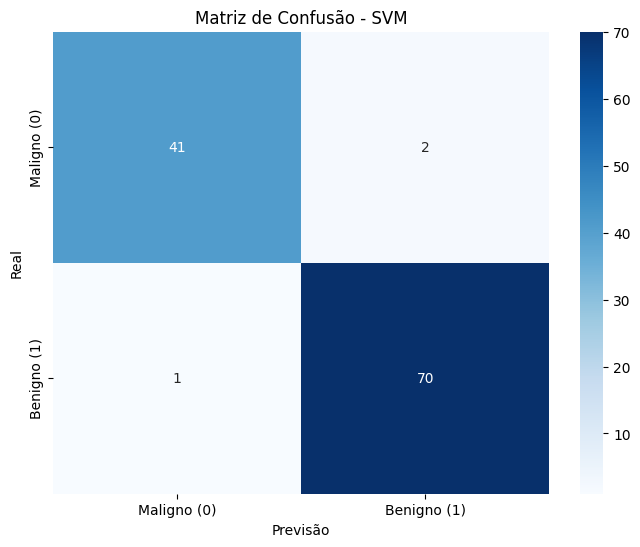

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Matriz de Confusão para o Melhor Modelo
conf_matrix = results[best_model_name]['Matriz de Confusão']

# Plotando a Matriz de Confusão
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Maligno (0)", "Benigno (1)"], yticklabels=["Maligno (0)", "Benigno (1)"])
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()


Gráfico Comparativo das Métricas (Acurácia, F1-score, Precisão, Recall)

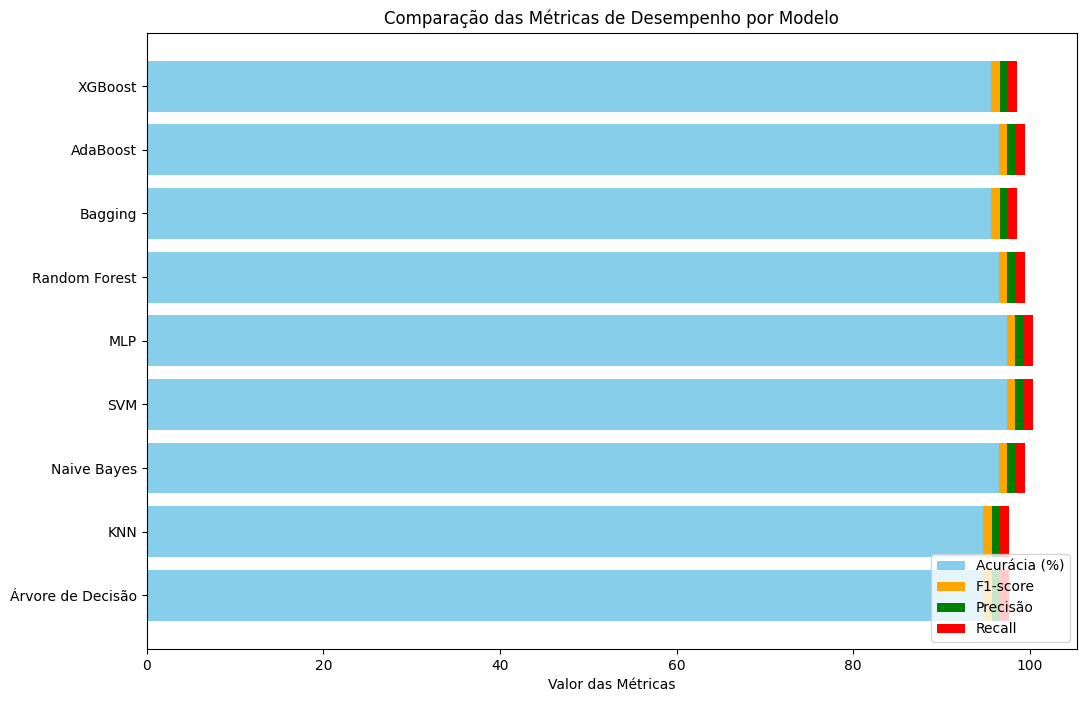

In [ ]:
# Preparando os dados para o gráfico
metrics = ['Acurácia (%)', 'F1-score', 'Precisão', 'Recall']
model_names = list(results.keys())

# Armazenando as métricas para cada modelo
accuracy_scores = [results[model]['Acurácia (%)'] for model in model_names]
f1_scores = [results[model]['F1-score'] for model in model_names]
precision_scores = [results[model]['Precisão'] for model in model_names]
recall_scores = [results[model]['Recall'] for model in model_names]

# Plotando as métricas
x = range(len(model_names))

plt.figure(figsize=(12, 8))
plt.barh(x, accuracy_scores, color='skyblue', label='Acurácia (%)')
plt.barh(x, f1_scores, left=accuracy_scores, color='orange', label='F1-score')
plt.barh(x, precision_scores, left=[i+j for i,j in zip(accuracy_scores, f1_scores)], color='green', label='Precisão')
plt.barh(x, recall_scores, left=[i+j+k for i,j,k in zip(accuracy_scores, f1_scores, precision_scores)], color='red', label='Recall')

# Ajustes finais
plt.xlabel('Valor das Métricas')
plt.yticks(x, model_names)
plt.title('Comparação das Métricas de Desempenho por Modelo')
plt.legend(loc='lower right')
plt.show()


Distribuição das Previsões

<ipython-input-11-b227dac08efd>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="Set2")


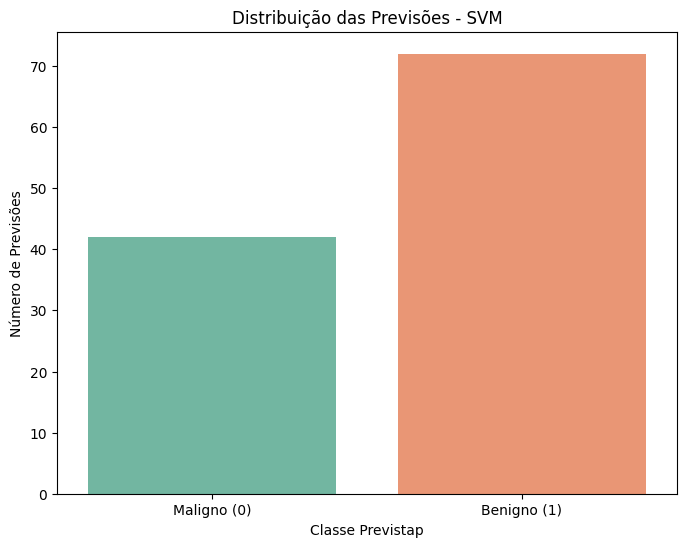

In [ ]:
# Distribuição das previsões
y_pred = best_model.predict(X_test)

# Plotando a distribuição das classes previstas
plt.figure(figsize=(8, 6))
sns.countplot(x=y_pred, palette="Set2")
plt.title(f'Distribuição das Previsões - {best_model_name}')
plt.xlabel('Classe Prevista')
plt.ylabel('Número de Previsões')
plt.xticks([0, 1], ['Maligno (0)', 'Benigno (1)'])
plt.show()